# GPAW + WannierBerri: Magnetism and spin-orbit coupling (bcc Fe)

In GPAW the spin-orbit coupling (SOC) is treated non-self-consistently. Therefore, there is no need to add it before wannierization. Instead, we can wannierised the collinear magnetic calculation and then add SOC in the wannierized Hamiltonian. Only after that we can specify the spin axis and compute the bandstructure and other properties (like AHC)

This also has the advantage that the Wannier functions are real (since they respect the time-reversal symmetry which is present in each spin channel separately) and respect all symmetries of the crystal structure, even those which are broken by the magnetization direction.

## Prerequisites
Make sure you have installed the following packages:

```
pip install wannierberri gpaw ase irrep
```


## Setup the parallelization

In [ ]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, FermiDirac, MixerSum
from wannierberri.parallel import Parallel, Serial

parallel_env= Parallel(num_cpus=16)

2025-10-22 19:13:54,127	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


initializing ray with  {'num_cpus': 16}


2025-10-22 19:13:56,144	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(Kpoint_and_neighbours_ray pid=606049) Warning: symmetrization did not converge in 100 iterations, final changes 0.38537401482960104, 0.3853737656757285
(Kpoint_and_neighbours_ray pid=606049) Warning: symmetrization did not converge in 100 iterations, final changes 0.3882069376449266, 0.3882068906892813
(Kpoint_and_neighbours_ray pid=606049) Warning: symmetrization did not converge in 100 iterations, final changes 0.3898311038547878, 0.389830759573306
(Kpoint_and_neighbours_ray pid=606049) Warning: symmetrization did not converge in 100 iterations, final changes 0.3909326094039763, 0.39093216408953
(Kpoint_and_neighbours_ray pid=606049) Warning: symmetrization did not converge in 100 iterations, final changes 0.39205905922021406, 0.3920583550825143
(Kpoint_and_neighbours_ray pid=606049) Warning: symmetrization did not converge in 100 iterations, final changes 0.39308362371275407, 0.3930835425809099



## Step 1: Gpaw calculation

### loading the GPAW calculators

If you want to skip the GPAW calculation, you can just load the pre-calculated calculators



In [ ]:
# calc_scf = GPAW("gpaw/Fe-scf.gpw")
# calc_nscf = GPAW("gpaw/Fe-nscf-irred-444.gpw")
# calc_bands = GPAW("gpaw/Fe-bands-path.gpw")

calc_scf = GPAW("gpaw/Fe-scf.gpw")
calc_nscf = GPAW("./Fe-nscf-irred-444.gpw")
calc_bands = GPAW("./Fe-bands-path.gpw")


### self-consistent calculation

In [2]:

a = 2.87 # Angstrom - lattice constant for bcc Fe
m = 2.2 # Bohr magneton - spin magnetic moment per atom

seed = "Fe"
lattice = a * np.array([[1, 1, 1], [-1, 1, 1], [-1, -1, 1]]) / 2

fe = Atoms('Fe',
           scaled_positions=[(0, 0, 0)],
           magmoms=[m],
           cell=lattice,
           pbc=True)

calc_scf = GPAW(mode=PW(600),
            xc='PBE',
            occupations=FermiDirac(width=0.01),
            kpts={'size': (8,8,8),},
            txt=f'Fe_scf.txt')
fe.calc = calc_scf
e = fe.get_potential_energy()
calc_scf.write(f'{seed}-scf.gpw')



### Non-self-consistent calculation in the irreducible Brillouin zone

Now we get the list of irreducible k-points (using irrep.SpaceGroup object) and perform a non-self-consistent calculation only on these k-points. 
Note, that here we use all symmetries of the crystal structure, even those which are broken by the magnetization direction, because they are still symmetries for each spin channel separately (including the time-reversal symmetry).

In [3]:
from irrep.spacegroup import SpaceGroup
sg = SpaceGroup.from_gpaw(calc_scf)
kpoints_irred = sg.get_irreducible_kpoints_grid([4, 4, 4])
calc_nscf = calc_scf.fixed_density(
    kpts=kpoints_irred,
    nbands=30,
    convergence={'bands': 24},
    txt=f'{seed}-nscf.txt')
calc_nscf.write(f'{seed}-nscf-irred-444.gpw', mode='all')

typat used for spacegroup detection (accounting magmoms): [26]


### Compute the dft bandstructure along a high-symmetry path

This is done to compare with the wannierized bandstructure later.

In [5]:
path_str = "GHPNGP"
calc_bands = calc_scf.fixed_density(
    nbands=30,
    symmetry='off',
    random=True,
    kpts={'path': path_str, 'npoints': 100},
    txt=f'{seed}-bands-path.txt',
    convergence={'bands': 24})
calc_bands.write(f'{seed}-bands-path.gpw', mode='all')


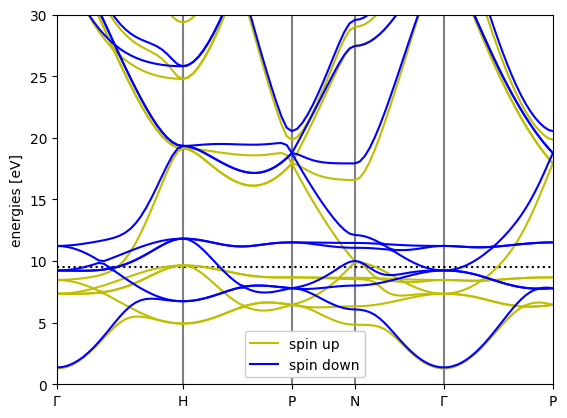

<Axes: ylabel='energies [eV]'>

In [6]:
bs_dft = calc_bands.band_structure()
bs_dft.plot(show=True, emin=0,emax=30.0)

## Step 2: Wannierization

#### 2.1 select projections

In this case we use sp3d2 and t2g projections on each iron atom.  One can also use the conventional s,p,d orbitals. 

In [7]:
from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from gpaw import GPAW
# gpaw_calc = calc_nscf #GPAW( "./Fe-nscf-irred-444.gpw")
sg = SpaceGroup.from_gpaw(calc_nscf)
projection_sp3d2 = Projection(position_num=[0, 0, 0], orbital='sp3d2', spacegroup=sg)
projection_t2g = Projection(position_num=[0, 0, 0], orbital='t2g', spacegroup=sg)
proj_set = ProjectionsSet([projection_sp3d2, projection_t2g])


typat used for spacegroup detection (accounting magmoms): [26]


### create the "w90 files"

Here we are NOT using the gpaw-wannier90 interface, and actually not creating the w90 files, but directly access the wavefunctions from the GPAW calculation, use symmetry operations from irrep, and create the necessary data to be used with wannierberri. Those files still retain the same naming convention as the w90 files for consistency, but htey are binary npz files, which are convenient to work with numpy


After creating those data, it is written to the disk, so that one can later load it. But be careful - if you change anything (e.g. the projections)  - do not forget to remove those files, otherwise you will load the old data! For that reason, here we set 'read_npz_list=[]' to force the creation of new data.

In [8]:
from wannierberri.w90files.w90data_soc import Wannier90dataSOC

w90data = Wannier90dataSOC.from_gpaw(
    calculator=calc_nscf,
    projections=proj_set,
    mp_grid=(4,4,4),
    read_npz_list=[],
    spacegroup=sg,
)

w90data.select_bands(win_min=-100,
                        win_max=50)

Using 'projections' for both spin up channel.
No projections_down provided; using projections_up for both spin channels.
finding num points from 2 projections
got irreducible=None, mp_grid=(4, 4, 4), seedname=wannier_soc-spin-0, files=['mmn', 'eig', 'amn', 'symmetrizer'], read_npz_list=[], write_npz_list=None, projections=ProjectionsSet with 9 Wannier functions and 0 free variables
Projection 0, 0, 0:['sp3d2'] with 6 Wannier functions on 1 points (6 per site)
Projection 0, 0, 0:['t2g'] with 3 Wannier functions on 1 points (3 per site), unk_grid=None, normalize=True
kpt_latt_grid=[[0.   0.   0.  ]
 [0.   0.   0.25]
 [0.   0.   0.5 ]
 [0.   0.25 0.5 ]
 [0.25 0.25 0.25]
 [0.25 0.25 0.5 ]
 [0.25 0.75 0.25]
 [0.5  0.5  0.5 ]]
mpgrid = [4 4 4], 8
detected grid=(np.int64(4), np.int64(4), np.int64(4)), selected_kpoints=[0 1 2 3 4 5 6 7]
self.irreducible=True
mpgrid = [4 4 4], 8


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/w90files/w90data.py:151: UserWarning: detected grid (np.int64(4), np.int64(4), np.int64(4)) od 64 kpoints, but only 8 kpoints are available.assuming that only irreducible kpoints are needed.
  warnings.warn(f"detected grid {grid} od {np.prod(grid)} kpoints, "


orbitals = ['sp3d2']
orbitals = ['t2g']
calculating Wannier functions for sp3d2 at [[0 0 0]]
calculating Wannier functions for t2g at [[0 0 0]]
D.shape [(8, 96, 6, 6), (8, 96, 3, 3)]
num_wann 9
D_wann_block_indices [[0 6]
 [6 9]]
saving to wannier_soc-spin-0.symmetrizer.npz : 
saving to wannier_soc-spin-0.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 9 Wannier functions and 0 free variables
Projection 0, 0, 0:['sp3d2'] with 6 Wannier functions on 1 points (6 per site)
Projection 0, 0, 0:['t2g'] with 3 Wannier functions on 1 points (3 per site)
saving to wannier_soc-spin-0.amn.npz : 
mpgrid = [4 4 4], 64
NK= 64, selected_kpoints = [0 1 2 3 4 5 6 7], kptirr = [0 1 2 3 4 5 6 7]
Shells found with weights [0.41728623] and tolerance 1.9302775581455037e-16
saving to wannier_soc-spin-0.mmn.npz : 
got irreducible=None, mp_grid=(4, 4, 4), seedname=wannier_soc-spin-1, files=['mmn', 'eig', 'amn', 'symmetrizer'], read_npz_list=[], write_npz_list=None, projections=ProjectionsSe

### Do the wannierization

at this step we also specify the frozen window, number of iterations, and whether to use site 
symmetry and localization. (when starting from irreducible BZ, site-symmetry is required anyway)

We also may use the outer window via w90data.select_bands if needed

In this case, both spin channels will be wannierised separately, starting from the same projections.There is also an option to specify different projections for different spin channels if needed. (See MnTe tutorial)

In [9]:

w90data.wannierise(
    froz_min=-1000,
    froz_max=20,
    num_iter=100,
    print_progress_every=10,
    sitesym=True,
    localise=True,
)



Symmetrizer_Uirr initialized for ikirr=0, kpt=0, [0. 0. 0.] with 96 symmetries, max error in included blocks: 1.3056926080711268e-14 ; excluded bands are [] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=1, kpt=1, [0.   0.   0.25] with 8 symmetries, max error in included blocks: 6.753223014464258e-16 ; excluded bands are [] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=2, kpt=2, [0.  0.  0.5] with 16 symmetries, max error in included blocks: 8.760422255333325e-16 ; excluded bands are [] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=3, kpt=3, [0.   0.25 0.5 ] with 4 symmetries, max error in included blocks: 3.37900622702967e-15 ; excluded bands are [] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=4, kpt=4, [0.25 0.25 0.25] with 16 symmetries, max error in included blocks: 9.352431718031025e-07 ; excluded bands are [] out o

### Create the System object to be used in WannierBerri calculations

It is called "System_w90" class, although it now does not use the w90 wannierization, but the class is the same.

Unlike the non-SOC systems, here we also specify the direction of the magnetization. We can later easily chanbge this direction without redoing the wannierization.

In [10]:
from wannierberri.system.system_soc import SystemSOC
theta = 0
phi = 0

system_soc = SystemSOC.from_wannier90data_soc(w90data=w90data, berry=True, silent=False)
system_soc.set_soc_axis(theta=theta, phi=phi, alpha_soc=1.0)
system_soc.save_npz("system_soc")


setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 1.435  1.435  1.435]
 [-1.435  1.435  1.435]
 [-1.435 -1.435  1.435]]
Number of wannier functions: 9
Number of R points: 89
Recommended size of FFT grid [4 4 4]
setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 1.435  1.435  1.435]
 [-1.435  1.435  1.435]
 [-1.435 -1.435  1.435]]
Number of wannier functions: 9
Number of R points: 89
Recommended size of FFT grid [4 4 4]


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/utility.py:68: UserWarning: usually need to provide either with real or reciprocal lattice.If you only want to generate a random symmetric tensor - that it fine
  warnings.warn("usually need to provide either with real or reciprocal lattice."
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sym_wann_2.py:258: UserWarning: symmetrization of matrices {'dV_soc_wann_0_0'} is not tested. use on your own risk
  warnings.warn(f"symmetrization of matrices {unknown} is not tested. use on your own risk")


nspin in SOC: 2
setting the Rvectors with wannier centers (cart): 
 [[-6.59525509e-01  3.57459156e-17  3.57459156e-17]
 [-6.85936186e-01  6.04761835e-17  6.04761835e-17]
 [ 6.59525509e-01  1.73597524e-17  1.73597524e-17]
 [ 6.85936186e-01 -6.04761835e-17 -6.04761835e-17]
 [ 1.73597524e-17 -6.59525509e-01 -1.73597524e-17]
 [-8.13853838e-17 -6.85936186e-01  8.13853838e-17]
 [-1.73597524e-17  6.59525509e-01  1.73597524e-17]
 [ 8.13853838e-17  6.85936186e-01 -8.13853838e-17]
 [-3.82689527e-17 -3.82689527e-17 -6.59525509e-01]
 [-1.35386848e-17 -1.35386848e-17 -6.85936186e-01]
 [ 3.82689527e-17  3.82689527e-17  6.59525509e-01]
 [ 1.35386848e-17  1.35386848e-17  6.85936186e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
 (red): 
 [[-

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sym_wann_2.py:258: UserWarning: symmetrization of matrices {'dV_soc_wann_1_1'} is not tested. use on your own risk
  warnings.warn(f"symmetrization of matrices {unknown} is not tested. use on your own risk")
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sym_wann_2.py:258: UserWarning: symmetrization of matrices {'overlap_up_down', 'dV_soc_wann_0_1'} is not tested. use on your own risk
  warnings.warn(f"symmetrization of matrices {unknown} is not tested. use on your own risk")


using magmoms 
 [[0.         0.         2.21212609]]
using magmoms 
 [[0.         0.         2.21212609]]
Saving SystemSOC to system_soc
saving system of class SystemSOC to system_soc
 properties: ['num_wann', 'real_lattice', 'iRvec', 'periodic', 'is_phonon', 'wannier_centers_cart', 'pointgroup', 'cell']
saving num_wann to system_soc/num_wann.npz
saving real_lattice to system_soc/real_lattice.npz
saving iRvec to system_soc/iRvec.npz
saving periodic to system_soc/periodic.npz
saving is_phonon to system_soc/is_phonon.npz
saving wannier_centers_cart to system_soc/wannier_centers_cart.npz
saving pointgroup to system_soc/pointgroup.npz
saving cell to system_soc/cell.npz
saving system of class System_w90 to system_soc/system_up
 properties: ['num_wann', 'real_lattice', 'iRvec', 'periodic', 'is_phonon', 'wannier_centers_cart', 'pointgroup']
saving num_wann
saving num_wann to system_soc/system_up/num_wann.npz
 - Ok!
saving real_lattice
saving real_lattice to system_soc/system_up/real_lattice.n

### Compute the wannierized bandstructure with SOC along the high-symmetry path

In [13]:
from wannierberri.grid import Path
from wannierberri.evaluate_k import evaluate_k_path
# from wannierberri.system.system_soc import SystemSOC
# system_soc = SystemSOC.from_npz("system_soc")

points = {"G": [0.0, 0.0, 0.0],
          "H": [0.5, -0.5, -0.5],
          "P": [0.75, 0.25, -0.25],
          "N": [0.5, 0.0, -0.5],
         }

path_str = "GHPNGP"
path = Path(system_soc,
            nodes=[points[p] for p in path_str],
            labels=[p for p in path_str],
            length=1000)   # length [ Ang] ~= 2*pi/dk

bands_wannier_soc= evaluate_k_path(system_soc, path=path, quantities=["spin"], parallel=parallel_env)
bands_wannier_up = evaluate_k_path(system_soc.system_up, path=path, parallel=parallel_env)
bands_wannier_dw = evaluate_k_path(system_soc.system_down, path=path, parallel=parallel_env)
                                

Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x76cbf87079b0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "spin" : <wannierberri.calculators.tabulate.Spin object at 0x76ce635aa600> :  Spin expectation :math:` \langle u | \mathbf{\sigma} | u \rangle`

 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x76ce63819250> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x76cbf87079b0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() 

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing   1373 K-points on  16 processes:     0.9452 ; per K-point          0.0007 ; proc-sec per K-point          0.0110
time1 =  0.12922000885009766
Totally processed 1373 K-points 
run() finished
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x76cbf843a330>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x76cbf87465d0> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x76cbf843a330>
All calculators are compatible
Symmetrization switc

## Plot the Bandstructure with and without SOC

/home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/ase/spectrum/band_structure.py:352: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = plt.legend(loc=loc)


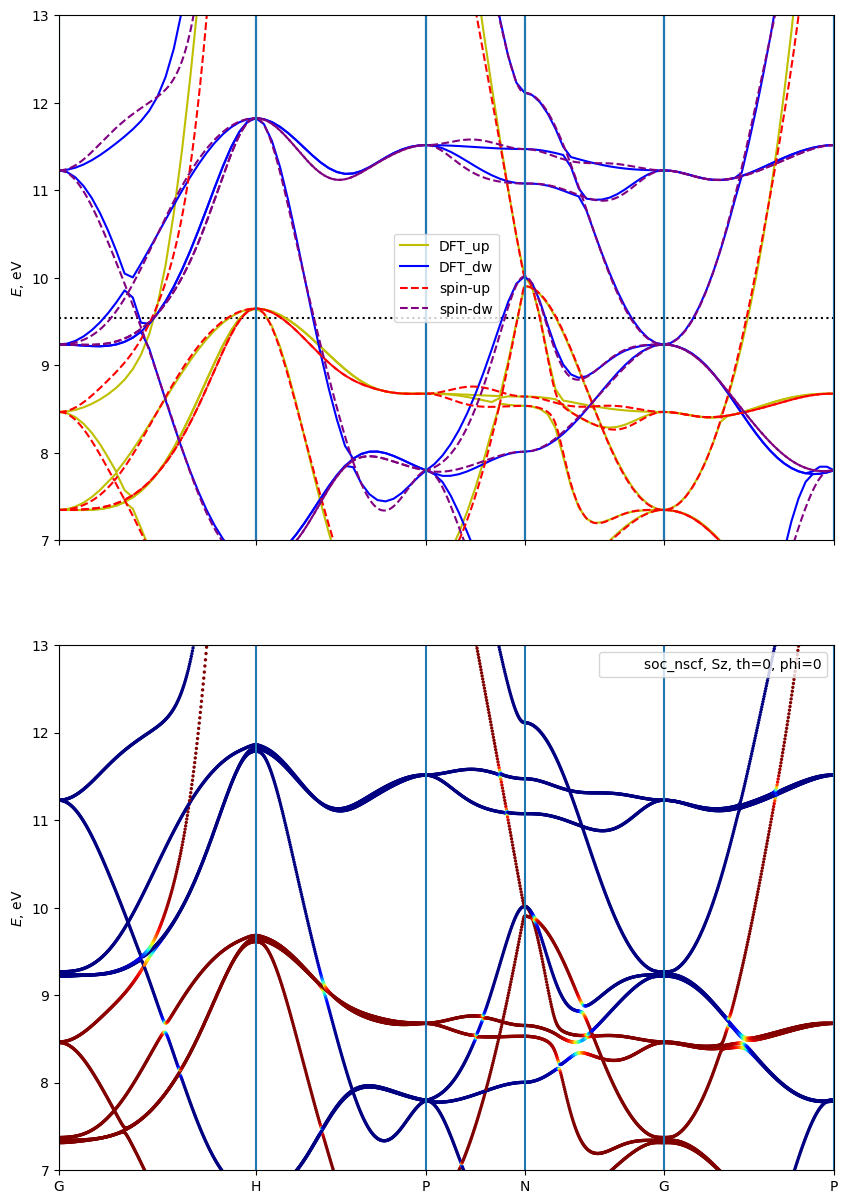

In [ ]:
EF = 9.53754
EF=0
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(10, 15))

theta = 0
phi = 0

bs_dft.plot(show=False, emin=0,emax=30.0, ax=axes[0] ,  label=["DFT_up", "DFT_dw"])

bands_wannier_soc.plot_path_fat(path=path,
                       Eshift=EF,
                       quantity="spin",
                       component="z",
                       mode="color",
                       label=f"soc_nscf, Sz, th={theta}, phi={phi}", 
                       axes=axes[1],
                       fatmax=2,
                        linecolor="orange",
                        close_fig=False,
                        show_fig=False,
                        kwargs_line=dict(linestyle='-', lw=0.0),
)
# 

bands_wannier_up.plot_path_fat(
                            path=path,
                            Eshift=EF,
                            axes=axes[0],
                            label="spin-up",
                            linecolor="red",
                            kwargs_line=dict(linestyle='--'),
                            close_fig=False,
                            show_fig=False)

bands_wannier_dw.plot_path_fat(
                        path=path,
                       label="spin-dw",
                       axes=axes[0],
                       Eshift=EF,
                       linecolor="purple",
                       kwargs_line=dict(linestyle='--'),
                       close_fig=False,
                       show_fig=False,)
plt.ylim(7, 13)
plt.show()



## AHC

### magnetization along [001] direction

Below we evaluate separately the "internal" (which depend only on the Hamiltonian) and external (which depend on position matrix elements) contributions to the anomalous Hall conductivity (AHC).  The motivation for this separation will be clear shortly

In [19]:
import os
import numpy as np
import wannierberri as wb
from wannierberri.system.system_soc import SystemSOC


system_soc_001 = SystemSOC.from_npz("system_soc")
theta=0
phi=0
system_soc_001.set_soc_axis(theta=theta, phi=phi, units="degrees")


grid = wb.grid.Grid(system_soc_001, NK=100)

EF = 9.53754
tetra = False

Efermi = np.linspace(EF - 0.5, EF + 0.5, 1001)

os.makedirs("results", exist_ok=True)
result_int = wb.run(system_soc_001,
        grid=grid,
        parallel=parallel_env,
        fout_name=f"results/Fe-soc-001",
        calculators={"ahc_int": wb.calculators.static.AHC(Efermi=Efermi, tetra=tetra, kwargs_formula={"external_terms": False})},
        adpt_num_iter=50,
        restart=False,
        print_progress_step=5,
        )


grid = wb.grid.Grid(system_soc, NK=50)
result_ext = wb.run(system_soc,
        grid=grid,
        parallel=parallel_env,
        fout_name=f"results/Fe-soc-001",
        calculators={"ahc_ext": wb.calculators.static.AHC(Efermi=Efermi, tetra=tetra, kwargs_formula={"internal_terms": False})},
        adpt_num_iter=25,
        restart=False,
        print_progress_step=5,
        )


loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
using magmoms 
 [[0.         0.         2.21212609]]
Minimal symmetric FFT grid :  [7 7 7]
Starting run()
Using the follwing calculators : 
############################################################

 'ahc_int'  :  <wannierberri.calculators.static.AHC object at 0x76cbf3eab890>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instru

### plot AHC vs energy

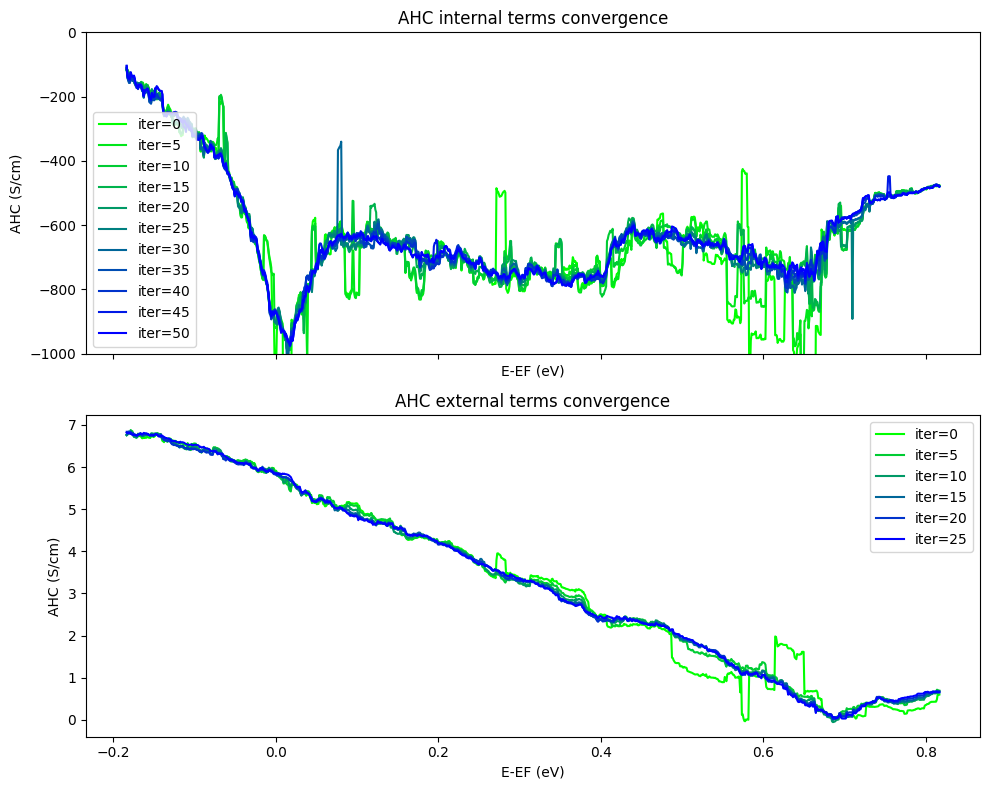

In [22]:
from matplotlib import pyplot as plt
import numpy as np
theta=0
phi=0
EF=9.22085

fig, axes = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(10, 8))
for i in range(0,51,5):
    color = (0, 1-i/50, i/50)
    res =  np.load(f"results/Fe-soc-001-ahc_int_iter-{i:04d}.npz")
    Efermi = res['Energies_0']
    ahc = res["data"]
    axes[0].plot(Efermi - EF, ahc[:,2]/100, label=f"iter={i}", color=color)
axes[0].set_title("AHC internal terms convergence")
axes[0].set_ylim(-1000, 0)
axes[0].set_xlabel("E-EF (eV)")
axes[0].set_ylabel("AHC (S/cm)")
axes[0].legend()
for i in range(0,26,5):
    color = (0, 1-i/25, i/25)
    res =  np.load(f"results/Fe-soc-001-ahc_ext_iter-{i:04d}.npz")
    Efermi = res['Energies_0']
    ahc = res["data"]
    axes[1].plot(Efermi - EF, ahc[:,2]/100, label=f"iter={i}", color=color)
axes[1].set_title("AHC external terms convergence")
axes[1].set_xlabel("E-EF (eV)")
axes[1].set_ylabel("AHC (S/cm)")
axes[1].legend()
plt.tight_layout()
plt.savefig("ahc_convergence.png", dpi=300)

We can observe 3 things, which are generally true, not only for AHC, but for most other effects:
1. The internal terms converge slower than the external ones.
2. The external terms usually give a smaller contribution. Often (but not always) it is negligible. However, check it for a particular material and effect.
3. The external terms take more time to evaluate per k-point. 

Thus, it makes sense to evaluate them separately, using different k-point grids and number of iterations for the adaptive integration.

## compare directions of magnetization

Now let us align the magnetization along [111] direction and compute the AHC again. (this time internal terms only)

In [24]:
import os
import numpy as np
import wannierberri as wb
from wannierberri.system.system_soc import SystemSOC


system_soc_111 = SystemSOC.from_npz("system_soc")
theta=np.arccos(1/np.sqrt(3))
phi=np.pi/4
system_soc_111.set_soc_axis(theta=theta, phi=phi, units="radians")


grid = wb.grid.Grid(system_soc_111, NK=100)

EF = 9.53754
tetra = False

Efermi = np.linspace(EF - 0.5, EF + 0.5, 1001)

os.makedirs("results", exist_ok=True)
result_int = wb.run(system_soc_111,
        grid=grid,
        parallel=parallel_env,
        fout_name=f"results/Fe-soc-111",
        calculators={"ahc_int": wb.calculators.static.AHC(Efermi=Efermi, tetra=tetra, kwargs_formula={"external_terms": False})},
        adpt_num_iter=50,
        restart=False,
        print_progress_step=5,
        )


loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
using magmoms 
 [[1.27717159 1.27717159 1.27717159]]
Minimal symmetric FFT grid :  [7 7 7]


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/utility.py:68: UserWarning: usually need to provide either with real or reciprocal lattice.If you only want to generate a random symmetric tensor - that it fine
  warnings.warn("usually need to provide either with real or reciprocal lattice."


Starting run()
Using the follwing calculators : 
############################################################

 'ahc_int'  :  <wannierberri.calculators.static.AHC object at 0x76cbf28e7c80>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`
############################################################
Calculation on  grid - checking calculators for compatibility
ahc_int <wannierberri.calculators.static.AHC object at 0x76cbf28e7c80>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[10 10 10], NKFFT=[10 10 10], NKtot=[100 100 100]
generating K_list
Done in 0.0029926300048828125 s 
excluding symmetry-equivalent K-points from initial grid
Done i

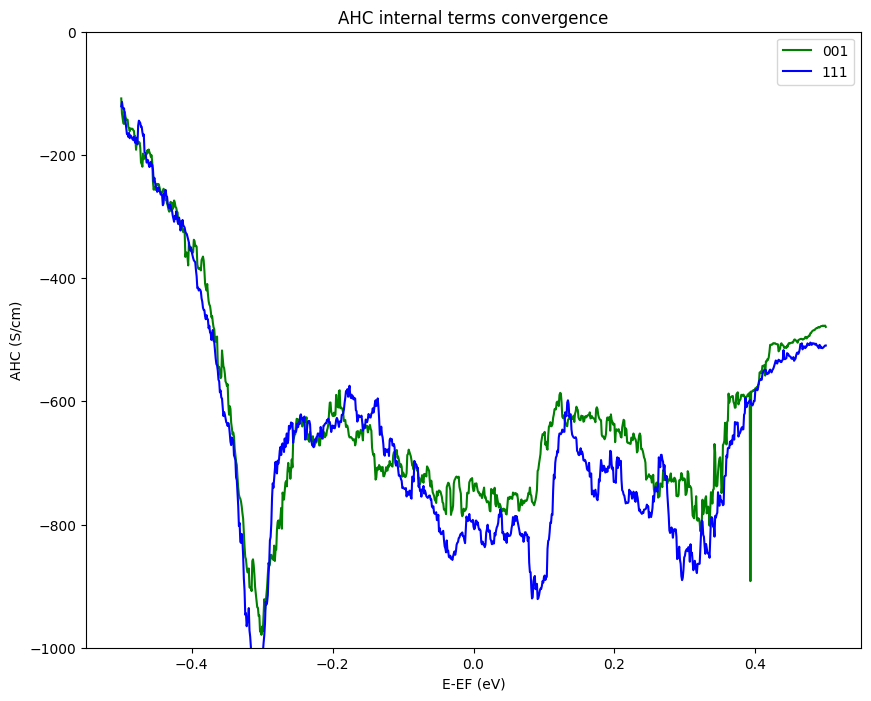

In [28]:
from matplotlib import pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 1, sharey=False, sharex=True, figsize=(10, 8))
res =  np.load(f"results/Fe-soc-001-ahc_int_iter-{i:04d}.npz")
Efermi = res['Energies_0']
ahc001 = res["data"]
axes.plot(Efermi - EF, ahc001[:,2]/100, label="001", color="green")
res =  np.load(f"results/Fe-soc-111-ahc_int_iter-{i:04d}.npz")
Efermi = res['Energies_0']
ahc111 = res["data"].sum(axis=1)/np.sqrt(3) # all three components are equal by symmetry
axes.plot(Efermi - EF, ahc111/100, label="111", color="blue")
axes.set_title("AHC internal terms convergence")
axes.set_ylim(-1000, 0)
axes.set_xlabel("E-EF (eV)")
axes.set_ylabel("AHC (S/cm)")
axes.legend()



We see that there is some difference, although it is not big. Moreover, we did not do a good convergence, so cannot draw any strong conclusions from this data. One needs to start from a denser k-point grid and more iterations to get converged results. Also, the starting DFT nscf grid should be denser.
